In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data-preparation-data-transformation').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


In [3]:
# Import data with automatically configured schema
df_h1 = spark.read.csv('H1.csv', header=True, inferSchema=True)
df_h2 = spark.read.csv('H2.csv', header=True, inferSchema=True)

# 3. Data Preparation

## 3.1. Select the Data

### 3.1.1. Select Rows

Remove invalid records:

- bookings with negative ADR
- cancelled city hotel booking with ADR = 5400
- bookings with "Undefined" distribution channel
- two cancelled city hotel bookings with "Undefined" market segment, which will be discarded alongside with bookings with "Undefined" distribution channel

In [4]:
## check dataframe shape before we perform any changes
print("H1.csv", (df_h1.count(), len(df_h1.columns)))
print("H2.csv", (df_h2.count(), len(df_h2.columns)))

H1.csv (40060, 31)
H2.csv (79330, 31)


In [5]:
## 1. remove bookings with negative ADR in H1; also run similar thing in H2 to ensure consistency
df_h1 = df_h1.filter('ADR >= 0')
df_h2 = df_h2.filter('ADR >= 0')

In [6]:
## 2. remove extremely high ADR (and it's cancelled anyway)
df_h2 = df_h2.filter('ADR != 5400')

In [7]:
## 3. remove bookings with Undefined distribution channel
df_h1 = df_h1.filter('DistributionChannel != "Undefined"')
df_h2 = df_h2.filter('DistributionChannel != "Undefined"')

In [8]:
## check dataframe shape before we perform any changes
print("H1.csv", (df_h1.count(), len(df_h1.columns)))
print("H2.csv", (df_h2.count(), len(df_h2.columns)))

H1.csv (40058, 31)
H2.csv (79325, 31)


### 3.1.2. Select Columns

Exclude BookingChanges, ReservationStatus, ReservationStatusDate

In [9]:
dropped_cols = ['BookingChanges','ReservationStatus','ReservationStatusDate']

df_h1 = df_h1.drop(*dropped_cols)
df_h2 = df_h2.drop(*dropped_cols)

In [10]:
## check dataframe shape before we perform any changes
print("H1.csv", (df_h1.count(), len(df_h1.columns)))
print("H2.csv", (df_h2.count(), len(df_h2.columns)))

H1.csv (40058, 28)
H2.csv (79325, 28)


## 3.2. Clean the Data

### 3.2.1. Inconsistent Coding Scheme

Clean Meal values: remove white spaces, convert Undefined to SC

In [11]:
import pyspark.sql.functions as F

def remove_whitespaces(spark_df, colname):
    """
    Remove extra whitespaces.
    """
    spark_df = spark_df.withColumn(
        colname,
        F.trim(F.col(colname))
    )
    
    return spark_df

def clean_meal(spark_df):
    """
    Remove extra whitespaces, reclassify "Undefined" as "SC".
    """
    CONDITION = "case when Meal == 'Undefined' then 'SC' else Meal end"
    spark_df = remove_whitespaces(spark_df, colname = 'Meal')
    spark_df = spark_df.withColumn(
        'Meal',
        F.expr(CONDITION)
    )
    
    return spark_df

In [12]:
df_h1 = clean_meal(df_h1)
df_h2 = clean_meal(df_h2)

Check results.

In [13]:
df_h1.select('Meal').toPandas()['Meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [14]:
df_h2.select('Meal').toPandas()['Meal'].unique()

array(['HB', 'BB', 'SC', 'FB'], dtype=object)

Remove trailing whitespaces in AssignedRoomType and ReservedRoomType.

In [15]:
df_h1.select('AssignedRoomType').head(3)

[Row(AssignedRoomType='C               '),
 Row(AssignedRoomType='C               '),
 Row(AssignedRoomType='C               ')]

In [16]:
df_h1.select('ReservedRoomType').head(3)

[Row(ReservedRoomType='C               '),
 Row(ReservedRoomType='C               '),
 Row(ReservedRoomType='A               ')]

In [17]:
df_h1 = remove_whitespaces(df_h1, colname='AssignedRoomType')
df_h2 = remove_whitespaces(df_h2, colname='AssignedRoomType')

df_h1 = remove_whitespaces(df_h1, colname='ReservedRoomType')
df_h2 = remove_whitespaces(df_h2, colname='ReservedRoomType')

Check results.

In [18]:
df_h1.select('AssignedRoomType').head(3)

[Row(AssignedRoomType='C'),
 Row(AssignedRoomType='C'),
 Row(AssignedRoomType='C')]

In [19]:
df_h1.select('ReservedRoomType').head(3)

[Row(ReservedRoomType='C'),
 Row(ReservedRoomType='C'),
 Row(ReservedRoomType='A')]

### 3.2.2. Data Errors

Remove records with extremely high ADR and "Undefined" values.

Have been removed in Select Data > Select Rows section.

### 3.2.3. Missing Values

Impute missing children in H2 (encoded as NA) to 0

In [20]:
CONDITION = "case when Children == 'NA' then '0' else Children end"

df_h2 = df_h2.withColumn(
    'Children',
    F.expr(CONDITION)
)

## 3.3. Construct the Data

Create HasChild, HasBaby, RequireCarPark, HasSpecialRequest.

In [21]:
import pyspark.sql.functions as F

def create_binary_column(spark_df, colname, new_colname, threshold=0):
    """
    Create a new boolean column based on particular threshold value.
    """
    CONDITION = "case when {0} > {1} then True else False end".format(colname, threshold)
    spark_df = spark_df.withColumn(
        new_colname,
        F.expr(CONDITION)
    )
    return spark_df

In [22]:
df_h1 = create_binary_column(df_h1, colname = 'Children', new_colname = 'HasChild')
df_h1 = create_binary_column(df_h1, colname = 'Babies', new_colname = 'HasBaby')
df_h1 = create_binary_column(df_h1, colname = 'RequiredCarParkingSpaces', new_colname = 'RequireCarPark')
df_h1 = create_binary_column(df_h1, colname = 'TotalOfSpecialRequests', new_colname = 'HasSpecialRequest')

df_h2 = create_binary_column(df_h2, colname = 'Children', new_colname = 'HasChild')
df_h2 = create_binary_column(df_h2, colname = 'Babies', new_colname = 'HasBaby')
df_h2 = create_binary_column(df_h2, colname = 'RequiredCarParkingSpaces', new_colname = 'RequireCarPark')
df_h2 = create_binary_column(df_h2, colname = 'TotalOfSpecialRequests', new_colname = 'HasSpecialRequest')

Create IsReservedRoomTypeEqualToAssigned.

In [23]:
df_h1 = df_h1.withColumn(
    'IsReservedRoomTypeEqualToAssigned',
    F.col('ReservedRoomType') == F.col('AssignedRoomType')
)

df_h2 = df_h2.withColumn(
    'IsReservedRoomTypeEqualToAssigned',
    F.col('ReservedRoomType') == F.col('AssignedRoomType')
)

Verify results.

In [24]:
df_h1.select(['IsReservedRoomTypeEqualToAssigned','ReservedRoomType','AssignedRoomType']).head()

Row(IsReservedRoomTypeEqualToAssigned=True, ReservedRoomType='C', AssignedRoomType='C')

In [25]:
df_h1.filter('IsReservedRoomTypeEqualToAssigned == False').select([
    'IsReservedRoomTypeEqualToAssigned','ReservedRoomType','AssignedRoomType'
]).head()

Row(IsReservedRoomTypeEqualToAssigned=False, ReservedRoomType='A', AssignedRoomType='C')

## 3.4. Integrate Various Data Sources

Append dataframes.

In [26]:
## check current dataframe shape
print("H1.csv", (df_h1.count(), len(df_h1.columns)))
print("H2.csv", (df_h2.count(), len(df_h2.columns)))

H1.csv (40058, 33)
H2.csv (79325, 33)


In [27]:
df_h1 = df_h1.withColumn('IsCityHotel', F.lit(False))
df_h2 = df_h2.withColumn('IsCityHotel', F.lit(True))

df_hotel = df_h1.union(df_h2)
print("Combined: ", (df_hotel.count(), len(df_hotel.columns)))

Combined:  (119383, 34)


In [28]:
## remove unused objects from memory
del df_h1, df_h2

In [29]:
# # Store current data as JSON
# # can't be stored as CSV because it contains arrays

# import json

# df_hotel.write.json('hotel_merged_data_preparation_preformatted.json')

# with open("hotel_merged_data_preparation_preformatted_schema.json", "w") as f:
#     json.dump(df_hotel.schema.jsonValue(), f)

## 3.5. Format the Data as Required

Restructure categorical values as boolean:
- Meal
- DistributionChannel
- MarketSegment
- CustomerType
- DepositType
- ArrivalDateMonth

In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

def encode_categorical_column(spark_df, colname, remove_original=False):
    """
    Encode categorical column of k distinct values into a vector of k-1 unique values.
    The vector will be named colnameVector.
    If remove_original=True, the original column is removed.
    """
    indexer = StringIndexer(inputCol = colname, outputCol = colname+'Idx')
    indexed = indexer.fit(spark_df).transform(spark_df)
    
    encoder = OneHotEncoder(dropLast = True, inputCol = colname+'Idx', outputCol = colname+'Vector')
    encoded = encoder.transform(indexed)
    
    if remove_original:
        dropped_cols = [colname, colname+'Idx']
    else:
        dropped_cols = [colname+'Idx']
        encoded = encoded.drop(*dropped_cols)
    
    return encoded

In [31]:
for col in ['Meal', 'MarketSegment','DistributionChannel','DepositType','CustomerType','ArrivalDateMonth']:
    df_hotel = encode_categorical_column(df_hotel, colname = col)

In [32]:
## preview
df_hotel.select(['Meal','MealVector']).distinct().show()

+----+-------------+
|Meal|   MealVector|
+----+-------------+
|  BB|(3,[0],[1.0])|
|  SC|(3,[2],[1.0])|
|  HB|(3,[1],[1.0])|
|  FB|    (3,[],[])|
+----+-------------+



In [33]:
print("Combined: ", (df_hotel.count(), len(df_hotel.columns)))

Combined:  (119383, 40)


**Determine the right data type**

- IsCanceled should be boolean
- Children should be integer
- IsRepeated, HasChild, HasBaby, RequireCarPark, HasSpecialRequest should be boolean

In [34]:
## before
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: string (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- DepositType: string (nullable = true)
 |-- Agent: str

In [35]:
df_hotel = df_hotel.withColumn(
    'Children',
    df_hotel['Children'].cast("integer")
)

boolean_cols = ['IsRepeatedGuest', 'HasChild', 'HasBaby', 'RequireCarPark', 'HasSpecialRequest']
for colname in boolean_cols:
    df_hotel = df_hotel.withColumn(
        colname,
        df_hotel[colname].cast("boolean")
    )

In [36]:
## after
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: boolean (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- DepositType: string (nullable = true)
 |-- Agent: s

In [37]:
## error: cannot store array in a CSV file
# df_hotel.write.csv('hotel_merged_data_preparation.csv', sep = ',', mode = 'overwrite', header = True)

## Store current data as JSON
## can't be stored as CSV because it contains arrays

# import json

# df_hotel.write.json('hotel_merged_data_preparation.json')

# with open("hotel_merged_data_preparation_schema.json", "w") as f:
#     json.dump(df_hotel.schema.jsonValue(), f)

# 4. Data Transformation

## 4.1. Reduce the Data

### 4.1.1. Feature Selection based on Logical Process

- Remove Country to avoid bias
- Remove Agent, Company (those are IDs)
- Remove ArrivalDateYear
- Remove redundant features (after variable constructions)

In [38]:
dropped_cols = [
    'Country','Agent','Company','ArrivalDateYear',
    'Children','Babies','Meal','MarketSegment','DistributionChannel','CustomerType',
    'DepositType','RequiredCarParkingSpaces','TotalOfSpecialRequests','ArrivalDateMonth',
    'AssignedRoomType','ReservedRoomType'
]

df_hotel = df_hotel.drop(*dropped_cols)

In [39]:
print("Combined: ", (df_hotel.count(), len(df_hotel.columns)))

Combined:  (119383, 24)


In [40]:
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- IsRepeatedGuest: boolean (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- DaysInWaitingList: integer (nullable = true)
 |-- ADR: double (nullable = true)
 |-- HasChild: boolean (nullable = false)
 |-- HasBaby: boolean (nullable = false)
 |-- RequireCarPark: boolean (nullable = false)
 |-- HasSpecialRequest: boolean (nullable = false)
 |-- IsReservedRoomTypeEqualToAssigned: boolean (nullable = true)
 |-- IsCityHotel: boolean (nullable = false)
 |-- MealVector: vector (nullable = true)
 |-- MarketSegmentVector: vector (nullable = true)
 |-- DistributionChannelVect

### 4.1.2. Feature Selection


In [41]:
## split train and test set before feature selection
## to avoid information leakage
RND = 722
df_train, df_test = df_hotel.randomSplit(weights = [0.7, 0.3], seed = RND)

In [42]:
def get_feature_importance_score(feature_importance, spark_df, feature_colname):
    """
    Extract feature importance scores and combine them with the feature name.
    """
    attributes_dict = spark_df.schema[feature_colname].metadata["ml_attr"]["attrs"]
    attributes_list = []
    
    for key in attributes_dict:
        attributes_list = attributes_list + attributes_dict[key]
    
    df_attributes = pd.DataFrame(attributes_list)
    df_attributes['score'] = df_attributes['idx'].apply(lambda x: feature_importance[x])
    df_attributes = df_attributes.sort_values(
        'score', 
        ascending = False
    ).drop(
        labels = 'idx', 
        axis = 1
    )
    
    return df_attributes

In [43]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

def calculate_feature_importance(spark_df, target_colname, feature_colname='features'):
    """
    Calculate feature importance using Random Forest.
    Return the spark dataframe with assembled feature vectors and 
    a Pandas dataframe containing the feature importance score.
    """
    
    assembler = VectorAssembler(
        inputCols = [colname for colname in spark_df.columns if colname != target_colname],
        outputCol = feature_colname
    )

    RND = 722
    rf = RandomForestClassifier(
        featuresCol = feature_colname,
        labelCol = target_colname,
        seed = RND,
        subsamplingRate = 0.8
    )
    
    pipeline = Pipeline(stages = [assembler, rf])
    model = pipeline.fit(spark_df)
    spark_df = model.transform(spark_df)
    
    df_feature_importance = get_feature_importance_score(
        model.stages[-1].featureImportances, 
        spark_df, 
        "features"
    )
    
    return spark_df, df_feature_importance

In [44]:
df_train_feats, df_feature_importance = calculate_feature_importance(
    df_train,
    target_colname = 'IsCanceled',
    feature_colname = 'features'
)

In [45]:
df_feature_importance.head()

,name,score
30,DepositTypeVector_Non Refund,0.326462
29,DepositTypeVector_No Deposit,0.194692
0,LeadTime,0.095660
14,HasSpecialRequest,0.080402
15,IsReservedRoomTypeEqualToAssigned,0.063305


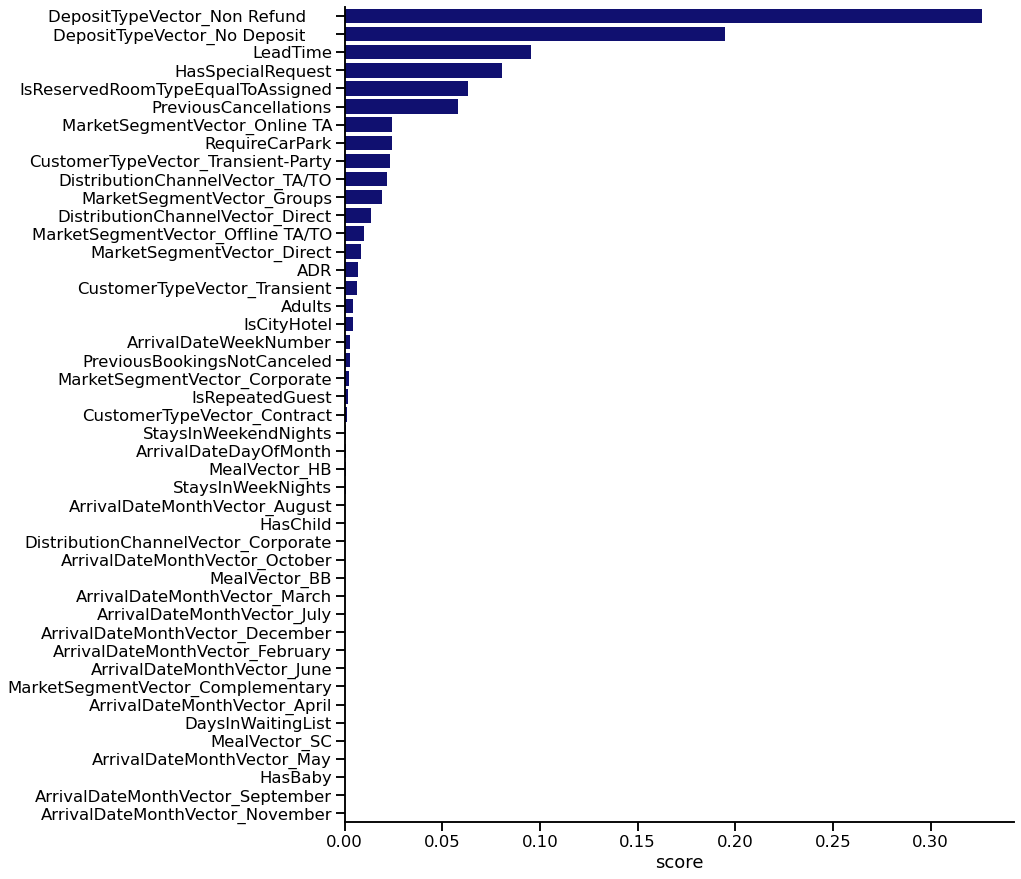

In [46]:
f, ax = plt.subplots(figsize = (12, 15))

sns.barplot(
    data = df_feature_importance,
    x = 'score',
    y = 'name',
    orient = 'h',
    color = 'navy'
)

plt.ylabel('')
sns.despine();

Remove HasBaby and ArrivalDateMonthVector.

In [47]:
dropped_cols = ['HasBaby', 'ArrivalDateMonthVector']
df_train = df_train.drop(*dropped_cols)
df_test = df_test.drop(*dropped_cols)

In [48]:
## check current dataframe shape
print("Training set", (df_train.count(), len(df_train.columns)))
print("Test set", (df_test.count(), len(df_test.columns)))

Training set (83696, 22)
Test set (35687, 22)


In [49]:
## Store information about train test split
df_train = df_train.withColumn('IsTestSet', F.lit(False))
df_test = df_test.withColumn('IsTetsSet', F.lit(True))

## Combine them back
df_hotel = df_train.union(df_test)

In [50]:
print("Current dataset", (df_hotel.count(), len(df_hotel.columns)))

Current dataset (119383, 23)


## 4.2. Project the Data

### 4.2.1. Transform the values

Log transformation on LeadTime & ADR

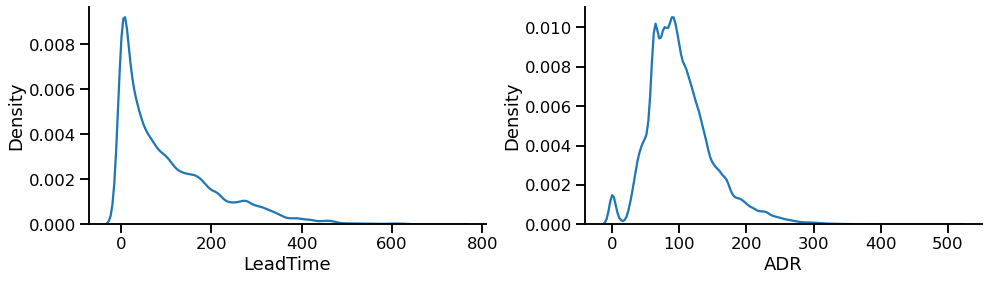

In [51]:
## before log transformation
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

i = 0
for colname in ['LeadTime', 'ADR']:
    values = df_hotel.select(colname).toPandas()[colname]
    
    sns.kdeplot(
        values,
        ax = ax[i]
    )
    
    ax[i].set_xlabel(colname)
    i += 1
    
sns.despine();

In [52]:
from pyspark.sql.functions import log10

for colname in ['LeadTime', 'ADR']:
    ## add 1 to prevent division by zero
    df_hotel = df_hotel.withColumn(
        colname, 
        log10(F.col(colname) + 1)
    )

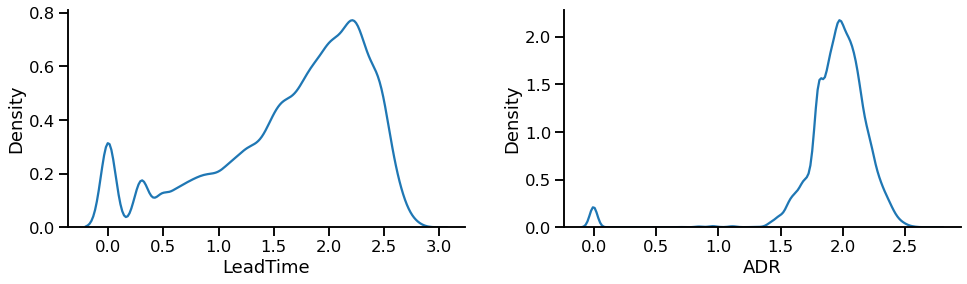

In [53]:
## after log transformation
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

i = 0
for colname in ['LeadTime', 'ADR']:
    values = df_hotel.select(colname).toPandas()[colname]
    
    sns.kdeplot(
        values,
        ax = ax[i]
    )
    
    ax[i].set_xlabel(colname)
    i += 1
    
sns.despine();

### 4.2.2. Balance the dataset

Oversample the **training set** via random sampling since we do not find a SMOTE implementation yet in Pyspark. [https://github.com/alivcor/SMORK](SMORK) only provides an implementation of SMOTE in Spark Scala API.

The oversampling is only performed on the training set.

In [54]:
## split the dataframe based on previous train-test-split
df_train = df_hotel.filter('IsTestSet == False')
df_test = df_hotel.filter('IsTestSet == True')

In [55]:
print("Majority", df_train.filter('IsCanceled == 0').count())
print("Minority", df_train.filter('IsCanceled == 1').count())
print("Ratio", df_train.filter('IsCanceled == 0').count() / df_train.filter('IsCanceled == 1').count())

Majority 52684
Minority 31012
Ratio 1.6988262608022702


In [56]:
RND = 722

additional_training_data = df_train.filter('IsCanceled == 1').sample(
    withReplacement = True,
    seed = RND,
    fraction = 0.7
)

additional_training_data.count()

21629

In [57]:
df_train_oversampled = df_train.union(additional_training_data)

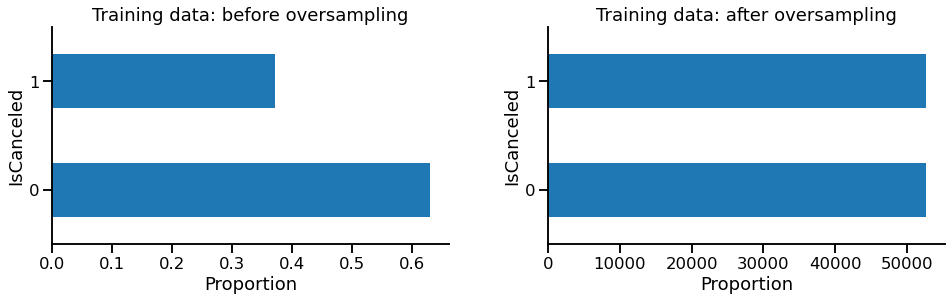

In [58]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

df_train.select('IsCanceled').toPandas()['IsCanceled'].value_counts(True).plot.barh(ax=ax[0]);
df_train_oversampled.select('IsCanceled').toPandas()['IsCanceled'].value_counts().plot.barh(ax=ax[1]);

ax[0].set_title("Training data: before oversampling")
ax[0].set_ylabel("IsCanceled")
ax[0].set_xlabel("Proportion")

ax[1].set_title("Training data: after oversampling")
ax[1].set_ylabel("IsCanceled")
ax[1].set_xlabel("Proportion")
sns.despine();

In [59]:
print("Training data before oversampling: {:,.0f} records".format(df_train.count()))
print("Training data after oversampling: {:,.0f} records".format(df_train_oversampled.count()))

Training data before oversampling: 83,696 records
Training data after oversampling: 105,325 records


Combine the training and test data into a dataframe.

In [60]:
df_hotel_transformed = df_train_oversampled.union(df_test)
print("Current dataset: {:,.0f} records with {} columns".format(
    df_hotel_transformed.count(), 
    len(df_hotel_transformed.columns)
))

Current dataset: 141,012 records with 23 columns


In [61]:
## remove objects from memory
del df_hotel, df_feature_importance, df_train

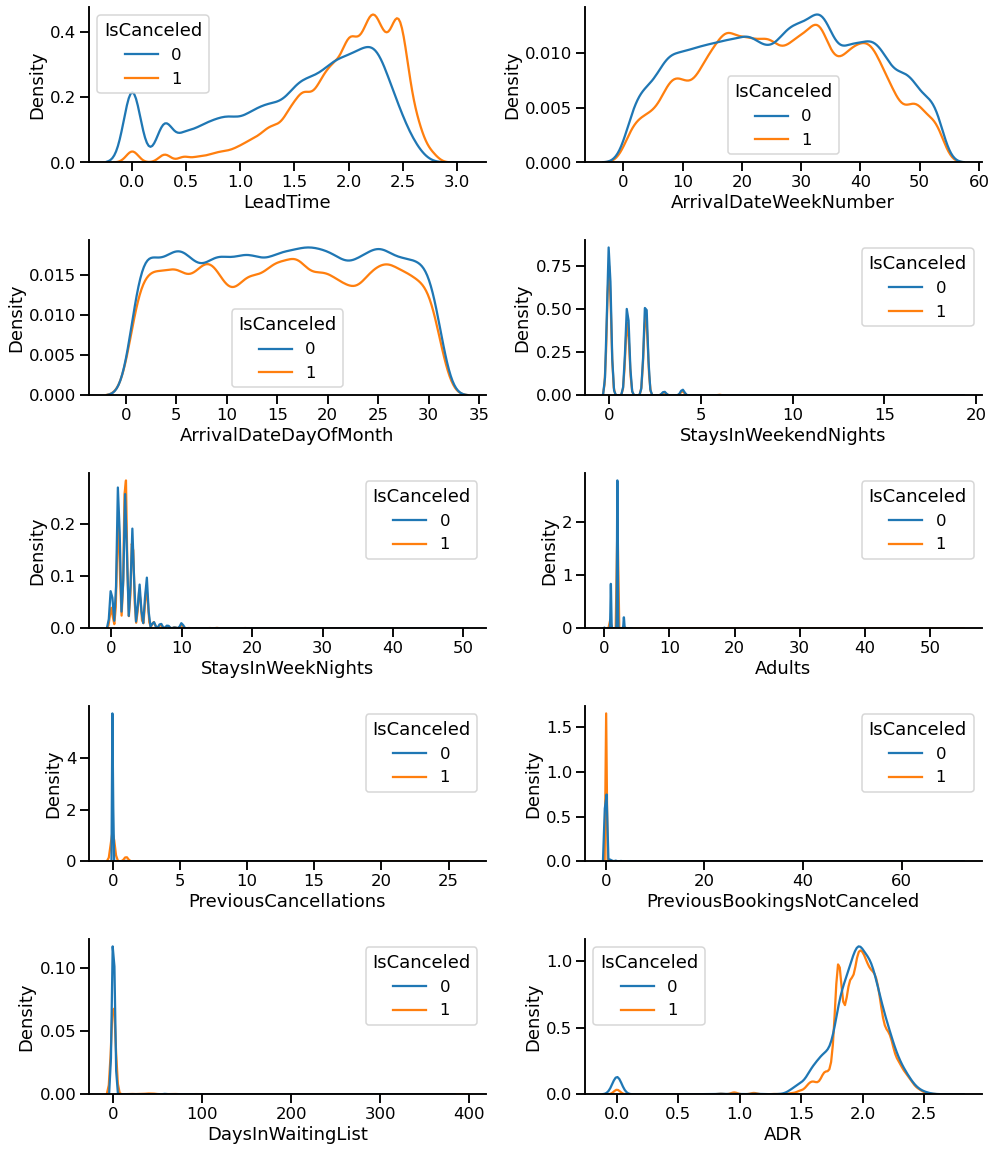

In [62]:
## plot the distribution of numeric values in the current dataset
## exclude the target class
cols = [
    item[0] for item in df_hotel_transformed.dtypes if (
        (item[1] != 'vector') & (item[1] != 'boolean') & (item[0] != 'IsCanceled')
    )
]

f, ax = plt.subplots(figsize = (16, 20), ncols = 2, nrows = 5)
plt.subplots_adjust(wspace = .25, hspace = .5)

i = 0
j = 0

for col in cols:
    sns.kdeplot(
        data = df_hotel_transformed.select([col, 'IsCanceled']).toPandas(),
        x = col,
        hue = 'IsCanceled',
        ax = ax[i][j]
    )
    ax[i][j].set_xlabel(col)
    
    if j == 1:
        i += 1
        j = 0
    else:
        j += 1
        
sns.despine();

In [63]:
## Store current data as JSON
## can't be stored as CSV because it contains arrays

# import json

# df_hotel_transformed.write.json('hotel_merged_data_transformation.json')

# with open("hotel_merged_data_transformation_schema.json", "w") as f:
#     json.dump(df_hotel_transformed.schema.jsonValue(), f)